In [1]:
from models import Autoencoder
from train import train, validate, save_checkpoint
from data_loader import load_cifar10_data
from torch.optim import Adam
import torch
from loggers import AE_LOGGER
from torch.utils.tensorboard import SummaryWriter
from metrics import FIDMetric
from mse_loss import CustomMSELoss

In [2]:
train_loader, val_loader, test_loader = load_cifar10_data()
# Print the total size (number of samples) of each dataset
print("Total number of training samples:", len(train_loader.dataset))
print("Total number of validation samples:", len(val_loader.dataset))
print("Total number of test samples:", len(test_loader.dataset))

Files already downloaded and verified
Files already downloaded and verified
Total number of training samples: 45000
Total number of validation samples: 5000
Total number of test samples: 10000


In [ ]:
# Hyperparameters
epochs = 1000
learning_rate = 0.0001
log_interval = 100
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
metric = FIDMetric(device)

# Model, loss function, and optimizer
model = Autoencoder().to(device)  # Example model; replace with any model
criterion = CustomMSELoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# TensorBoard writer
logger = AE_LOGGER(SummaryWriter())
best_checkpoint_path = "AE_MODEL2/best_ckpt.pth"

# Training loop
best_val_loss = float('inf')
for epoch in range(1, epochs + 1):
    train(model, train_loader, criterion, optimizer, device, epoch, logger, log_interval)
    val_loss,fid_score = validate(model, val_loader, criterion, device, epoch, logger,metric=metric)
    
    # Save checkpoint if validation loss improves
    if val_loss < best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. Saving model...")
        save_checkpoint(model,best_checkpoint_path)

/home/nazara/Data/UCU/GENAI/env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nazara/Data/UCU/GENAI/env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1 [Validation]:   9%|▉         | 7/79 [00:00<00:00, 95.34it/s]


additional_logs are not defined for this logger


TypeError: '<' not supported between instances of 'tuple' and 'float'

In [3]:
# First cell - Initialize model and load checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_checkpoint_path = "AE_MODEL/best_ckpt.pth"

model = Autoencoder().to(device)
checkpoint = torch.load(best_checkpoint_path, map_location=device)
model.load_state_dict(checkpoint)
model.eval();

/tmp/ipykernel_894206/773974668.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_checkpoint_path, map_location=device)


In [4]:
# Second cell - Get test images
test_images = []
for batch, _ in test_loader:
    test_images.append(batch)
    if len(torch.cat(test_images)) >= 2000:
        break
test_images = torch.cat(test_images)[:2000]

In [11]:
# Third cell - Generate images
generated_images = []
batch_size = 64

with torch.no_grad():
    for i in range(0, 2000, batch_size):
        curr_batch_size = min(batch_size, 2000 - i)
        gen_batch = model.generate(curr_batch_size, device=device)
        generated_images.append(gen_batch)

generated_images = torch.cat(generated_images)

In [12]:
# Fourth cell - Compute FID
metric = FIDMetric(device)
fid_score = metric(test_images, generated_images)
print(f"FID Score: {fid_score:.2f}")

FID Score: 401.84


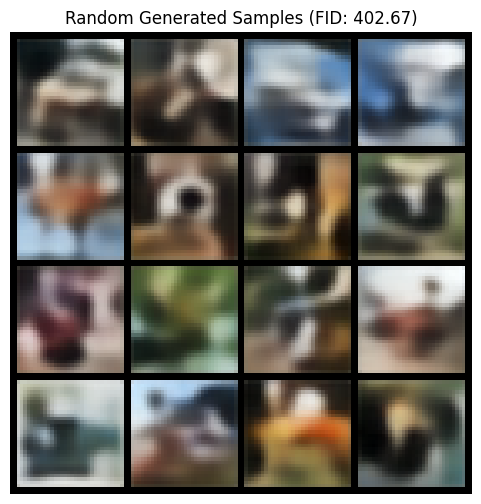

In [8]:
# Fifth cell - Visualize 16 random samples
import random
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Get 16 random indices
indices = random.sample(range(len(generated_images)), 16)
vis_samples = generated_images[indices]

# Create and display grid
grid = make_grid(vis_samples, nrow=4, padding=2, normalize=True)
plt.figure(figsize=(6, 6))
plt.imshow(grid.cpu().permute(1, 2, 0).numpy())
plt.axis('off')
plt.title(f'Random Generated Samples (FID: {fid_score:.2f})')
plt.show()